In [1]:
pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import ast
import numpy as np
import matplotlib.colors as colors
import networkx as nx
from scipy.sparse import coo_matrix
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely import wkt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from haversine import haversine

In [7]:
from script import epci_features

/home/onyxia/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:142: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/statapp/script.py:151: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Us

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [5]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
from script import df_dossier_complet_brut, mairies, df_epci_contours

ImportError: cannot import name 'mairies' from 'script' (/home/onyxia/statapp/script.py)

# Calculs des distances des trajets dans la base mobpro

In [4]:
mairies[['lat', 'lon']] = mairies['Coordonnées'].str.split(',', expand=True).astype(float)
mairies_unique = mairies.drop_duplicates(subset='Code INSEE')

# Calculer le trajet interne
def approx_internal_distance(geom):
    bounds = geom.bounds  # (minx, miny, maxx, maxy)
    point_min = (bounds[1], bounds[0])  # (lat_min, lon_min)
    point_max = (bounds[3], bounds[2])  # (lat_max, lon_max)
    return haversine(point_min, point_max)

contours_comm['distance_intra'] = contours_comm['geometry'].apply(approx_internal_distance)/2 # On divise par 2 la diag pour les intra
distance_intra_dict = contours_comm.set_index('INSEE_COM')['distance_intra'].to_dict() # Dictionnaire des distances intra

# Calculer les trajets entre villes
mairies_unique = mairies.drop_duplicates(subset='Code INSEE') # Garder une seule mairie pour chaque ville
coords_mairies = mairies_unique.set_index('Code INSEE')[['lat', 'lon']].to_dict('index') 

# Fonction pour calculer la distance
def calculer_distance(code_depart, code_arrivee):
    if code_depart == code_arrivee:
        # Trajet intra-communal
        return distance_intra_dict.get(code_depart, 3.0)  # Fallback 3km si pas trouvé
    else:
        # Trajet intercommunal
        coords_depart = coords_mairies.get(code_depart)
        coords_arrivee = coords_mairies.get(code_arrivee)
        
        if coords_depart is None or coords_arrivee is None:
            return None  # Impossible de calculer (missing coords)
        
        return haversine((coords_depart['lat'], coords_depart['lon']),
                         (coords_arrivee['lat'], coords_arrivee['lon']))

df_mobpro_brut['distance_km'] = df_mobpro_brut.apply(
    lambda row: calculer_distance(row['COMMUNE'], row['DCLT']),
    axis=1)


NameError: name 'mairies' is not defined

In [ ]:
df_mobpro_brut.sample()

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL,distance_km
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société",4.163392
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés,4.163392
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société",4.163392
3,3,01001,ZZZZZ,99999,01001,55,2,Z,3,21,...,21,10,1,1,1,41,1,Pas de transport,"Artisans, commerçants, chef de société",4.163392
4,4,01001,ZZZZZ,99999,01001,55,2,Z,13,22,...,22,10,1,5,1,41,3,"Voiture, camion, fourgonnette","Artisans, commerçants, chef de société",4.163392
5,5,01001,ZZZZZ,99999,01001,55,1,Z,15,21,...,21,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Agriculteurs,4.163392
6,6,01001,ZZZZZ,99999,01001,30,5,Z,14,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Employés,4.163392
7,7,01001,ZZZZZ,99999,01001,30,6,Z,15,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Ouvriers,4.163392
8,8,01001,ZZZZZ,99999,01001,25,5,Z,14,16,...,10,10,1,1,1,41,2,Pas de transport,Employés,4.163392
9,9,01001,ZZZZZ,99999,01001,35,4,Z,17,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Professions intermédiaires,4.163392


# Obtention du dataframe EPCI et ses features

In [7]:
"""OBTENTION DE gdf_epci_metropole IGNORANT LES EPCI HORS FRANCE METROPOLITAINE"""

def est_metropole(liste_departements):
    """
    Exclut les DOM-TOM et la Corse, ne conserve que la métropole.
    """
    if isinstance(liste_departements, str):
        try:
            liste_departements = ast.literal_eval(liste_departements)
        except Exception:
            return False  # La chaîne n'était pas une liste valide

    # Filtrage : ignorer les départements trop longs
    liste_departements = [str(dep).strip() for dep in liste_departements if len(str(dep).strip()) <= 3]

    for dep in liste_departements:
        # Exclure les codes contenant des lettres (ex: 2A ou 2B pour la Corse)
        if any(c.isalpha() for c in dep):
            return False

        try:
            if int(dep) >= 970:
                return False
        except ValueError:
            return False  # On exclut si ce n'est pas un entier valide

    return True


In [8]:
gdf_epci_metropole = df_epci_contours[df_epci_contours['INSEE_DEP'].apply(est_metropole)]

In [ ]:
# Convertir geometry de chaine de caractère à géométries spatiales
def convert_if_string(geom):
    if isinstance(geom, str):
        return wkt.loads(geom)
    return geom


In [ ]:
gdf_epci_metropole['geometry'] = gdf_epci_metropole['geometry'].apply(convert_if_string)

# Créer un GeoDataFrame
gdf_epci_metropole = gpd.GeoDataFrame(gdf_epci_metropole, geometry='geometry')

# Tracer les contours des EPCI
fig, ax = plt.subplots(figsize=(10, 10))
gdf_epci_metropole.plot(ax=ax, edgecolor='black', facecolor='none')
plt.title('Contours des EPCI')
plt.axis('off')
plt.show()

In [10]:
gdf_epci_metropole.sample()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP
57,57,200030633,"['Busigny', 'Élincourt', 'Saint-Vaast-en-Cambr...","['59118', '59191', '59547', '59395', '59498', ...","['59', '59', '59', '59', '59', '59', '59', '59...",63789.0,3752.046089,26690.307426,20621.644058,"POLYGON ((721058.8 6990864, 720932.9 6990793.8...",True


In [24]:
# Fonction pour convertir les chaînes de caractères en listes
def convert_to_list(value):
    if isinstance(value, str):
        # Supprime les caractères indésirables et divise la chaîne
        cleaned = value.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
        # Divise la chaîne en éléments individuels
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        return items
    elif isinstance(value, list):
        return value
    return []

# 2. Définir les tranches de distances
distance_bins = [0, 10, 20, 30, 40, 50, float('inf')]
distance_labels = ['<10km', '<20km', '<30km', '<40km', '<50km', '>50km']

# 3. Définir les catégories de transport
transport_categories = {
    'vert': [1, 2, 3],
    'jaune': [6],
    'rouge': [4, 5]
}

# Créer un dictionnaire pour stocker les résultats
results = {}

In [ ]:
# 1. Convertir les colonnes de codes INSEE en listes
print("Conversion des codes INSEE en listes...")
gdf_epci_metropole['INSEE_COM_list'] = gdf_epci_metropole['INSEE_COM'].apply(convert_to_list)
gdf_epci_metropole['INSEE_DEP_list'] = gdf_epci_metropole['INSEE_DEP'].apply(convert_to_list)

## Calcul des features (+1h)

In [24]:
from tqdm import tqdm

# Boucle sur chaque EPCI avec barre de progression
print("Calcul des statistiques par EPCI...")
for idx, epci_row in tqdm(gdf_epci_metropole.iterrows(), total=gdf_epci_metropole.shape[0], desc="Traitement des EPCI"):
    epci_communes = set(epci_row['INSEE_COM_list'])
    epci_code = epci_row['SIREN_EPCI']
    
    results[epci_code] = {}
    
    for transport_name, transport_codes in transport_categories.items():
        transport_data = df_mobpro_brut[df_mobpro_brut['TRANS'].isin(transport_codes)]
        
        entrants = transport_data[
            (~transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        sortants = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (~transport_data['COMMUNE'].isin(epci_communes))
        ]
        internes = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        
        for i, (lower, upper) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
            label = distance_labels[i]
            
            entrants_bin = entrants[(entrants['distance_km'] > lower) & (entrants['distance_km'] <= upper)]
            results[epci_code][f'nb_entrant_{label}_{transport_name}'] = entrants_bin['IPONDI'].sum()
            results[epci_code][f'distance_entrant_{label}_{transport_name}'] = (
                (entrants_bin['distance_km'] * entrants_bin['IPONDI']).sum() / entrants_bin['IPONDI'].sum()
                if entrants_bin['IPONDI'].sum() > 0 else 0
            )
            
            sortants_bin = sortants[(sortants['distance_km'] > lower) & (sortants['distance_km'] <= upper)]
            results[epci_code][f'nb_sortant_{label}_{transport_name}'] = sortants_bin['IPONDI'].sum()
            results[epci_code][f'distance_sortant_{label}_{transport_name}'] = (
                (sortants_bin['distance_km'] * sortants_bin['IPONDI']).sum() / sortants_bin['IPONDI'].sum()
                if sortants_bin['IPONDI'].sum() > 0 else 0
            )
        
        results[epci_code][f'nb_intra_{transport_name}'] = internes['IPONDI'].sum()
        results[epci_code][f'distance_intra_{transport_name}'] = (
            (internes['distance_km'] * internes['IPONDI']).sum() / internes['IPONDI'].sum()
            if internes['IPONDI'].sum() > 0 else 0
        )


Calcul des statistiques par EPCI...


Traitement des EPCI: 100%|██████████| 1225/1225 [1:18:15<00:00,  3.83s/it]


In [28]:

# Convertir les résultats en DataFrame
print("Conversion des résultats en DataFrame...")
results_df = pd.DataFrame.from_dict(results, orient='index')

# Joindre les résultats au GeoDataFrame original
print("Jointure des résultats au GeoDataFrame...")
gdf_epci_metropole_enrichi = gdf_epci_metropole.merge(results_df, left_on='SIREN_EPCI', right_index=True, how='left')

# Afficher un aperçu des colonnes ajoutées
print("\nColonnes ajoutées:")
new_columns = [col for col in gdf_epci_metropole_enrichi.columns if col not in gdf_epci_metropole.columns]
print(f"Nombre de nouvelles colonnes: {len(new_columns)}")
print(new_columns[:10])  # Afficher les 10 premières nouvelles colonnes

print("\nAperçu du GeoDataFrame enrichi:")
print(gdf_epci_metropole_enrichi.head())

# Le GeoDataFrame enrichi est maintenant prêt à être utilisé
# Il contient toutes les statistiques demandées par EPCI


Conversion des résultats en DataFrame...
Jointure des résultats au GeoDataFrame...

Colonnes ajoutées:
Nombre de nouvelles colonnes: 78
['nb_entrant_<10km_vert', 'distance_entrant_<10km_vert', 'nb_sortant_<10km_vert', 'distance_sortant_<10km_vert', 'nb_entrant_<20km_vert', 'distance_entrant_<20km_vert', 'nb_sortant_<20km_vert', 'distance_sortant_<20km_vert', 'nb_entrant_<30km_vert', 'distance_entrant_<30km_vert']

Aperçu du GeoDataFrame enrichi:
   Unnamed: 0 SIREN_EPCI                                                NOM  \
0           0  200000172  ['Marignier', 'Contamine-sur-Arve', 'Glières-V...   
1           1  200000438  ['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...   
2           2  200000545  ['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...   
3           3  200000628  ['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...   
4           4  200000800  ['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...   

                                           INSEE_COM  \
0  ['74164', '74087

In [29]:
gdf_epci_metropole_enrichi.head()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,...,nb_entrant_<50km_rouge,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge
0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3 6556343.9, 967045.7 6556329...",...,23.424631,41.855623,98.852138,45.998058,103.969510,216.047856,271.156739,181.420870,3588.632912,5.668859
1,1,200000438,"['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...","['44050', '44129', '44152', '44098', '44068', ...","['44', '44', '44', '44', '44', '44', '44', '44...",35917.0,2756.235128,15784.280047,14384.550345,"POLYGON ((325044.8 6719783.3, 325064.2 6719753...",...,1102.793630,45.257024,253.071753,45.521902,490.328609,157.114357,187.438224,143.643734,4143.172699,7.481773
2,2,200000545,"['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...","['10114', '10341', '10323', '10164', '10220', ...","['10', '10', '10', '10', '10', '10']",18739.0,874.965660,8665.218943,5446.249610,"POLYGON ((751763.4 6819199.7, 751729 6819176.1...",...,32.553518,44.753960,87.961210,44.483349,452.965644,132.967389,175.929027,134.837601,2352.085074,4.782090
3,3,200000628,"['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...","['84064', '84078', '84083', '84063', '84019']","['84', '84', '84', '84', '84']",24224.0,1442.982297,10773.779439,7526.326339,"POLYGON ((841785.2 6347339.5, 841574.2 6347339...",...,85.004987,44.079470,104.088887,44.554021,293.441754,192.753391,229.911823,162.979680,3048.432489,5.904768
4,4,200000800,"['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...","['41046', '41036', '41296', '41161', '41106', ...","['41', '41', '41', '41', '41', '41']",10437.0,550.174086,4746.154398,3763.453777,"POLYGON ((631422.5 6721239, 631378 6721141.6, ...",...,151.569186,42.964703,73.995380,43.829028,130.487340,144.713486,138.297036,116.352574,1653.353772,7.436458


On a enregistré sur S3 ce dataframe final pour ne pas avoir à relancer le code à chaque fois en entier (car très long) et il s'appelle désormais epci_features

# Clustering 

In [8]:
epci_features.sample()

,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,...,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge,cluster
926,955,955,243900479,"['Bellefontaine', 'Morbier', 'Longchaumois', '...","['39047', '39367', '39297', '39368']","['39', '39', '39', '39']",9150.0,722.077491,4238.028466,3635.262981,...,44.237945,35.127,46.048579,64.39993,694.033132,87.401198,282.418502,1260.043248,6.027103,0


In [ ]:
df_kmeans = pd.DataFrame(index=epci_features.index)

# Définir les couleurs et les tranches de distance
couleurs = ['rouge', 'jaune', 'vert']
distances = ['<10km', '<20km', '<30km', '<40km', '<50km', '>50km']

# Calculer les distances totales (flux × distance moyenne) pour chaque combinaison
for couleur in couleurs:
    # Traiter les flux entrants/sortants par distance
    for dist in distances:
        # Flux entrants
        nb_entrant = f"nb_entrant_{dist}_{couleur}"
        dist_entrant = f"distance_entrant_{dist}_{couleur}"
        if nb_entrant in epci_features.columns and dist_entrant in epci_features.columns:
            df_kmeans[f"distance_totale_entrant_{dist}_{couleur}"] = (
                epci_features[nb_entrant] * epci_features[dist_entrant]
            )
        
        # Flux sortants
        nb_sortant = f"nb_sortant_{dist}_{couleur}"
        dist_sortant = f"distance_sortant_{dist}_{couleur}"
        if nb_sortant in epci_features.columns and dist_sortant in epci_features.columns:
            df_kmeans[f"distance_totale_sortant_{dist}_{couleur}"] = (
                epci_features[nb_sortant] * epci_features[dist_sortant]
            )
    
    # Traiter les flux internes
    nb_intra = f"nb_intra_{couleur}"
    dist_intra = f"distance_intra_{couleur}"
    if nb_intra in epci_features.columns and dist_intra in epci_features.columns:
        df_kmeans[f"distance_totale_intra_{couleur}"] = (
            epci_features[nb_intra] * epci_features[dist_intra]
        )

# Ajouter éventuellement 'Nb actifs occupés en 2021' comme feature
if 'Nb actifs occupés en 2021' in epci_features.columns:
    df_kmeans['nb_actifs'] = epci_features['Nb actifs occupés en 2021']

df_kmeans['ratio'] = (
    epci_features['nb_sortant_<10km_vert'] + epci_features['nb_sortant_<20km_vert'] +
    epci_features['nb_sortant_<30km_vert'] + epci_features['nb_sortant_<40km_vert'] +
    epci_features['nb_sortant_<50km_vert'] + epci_features['nb_sortant_>50km_vert'] +
    epci_features['nb_sortant_<10km_jaune'] + epci_features['nb_sortant_<20km_jaune'] +
    epci_features['nb_sortant_<30km_jaune'] + epci_features['nb_sortant_<40km_jaune'] +
    epci_features['nb_sortant_<50km_jaune'] + epci_features['nb_sortant_>50km_jaune'] +
    epci_features['nb_sortant_<10km_rouge'] + epci_features['nb_sortant_<20km_rouge'] +
    epci_features['nb_sortant_<30km_rouge'] + epci_features['nb_sortant_<40km_rouge'] +
    epci_features['nb_sortant_<50km_rouge'] + epci_features['nb_sortant_>50km_rouge']) / (epci_features['nb_entrant_<10km_vert'] + epci_features['nb_entrant_<20km_vert'] + epci_features['nb_entrant_<30km_vert'] + epci_features['nb_entrant_<40km_vert'] + epci_features['nb_entrant_<50km_vert'] + epci_features['nb_entrant_>50km_vert'] + epci_features['nb_entrant_<10km_jaune'] + epci_features['nb_entrant_<20km_jaune'] + epci_features['nb_entrant_<30km_jaune'] + epci_features['nb_entrant_<40km_jaune'] + epci_features['nb_entrant_<50km_jaune'] + epci_features['nb_entrant_>50km_jaune'] + epci_features['nb_entrant_<10km_rouge'] + epci_features['nb_entrant_<20km_rouge'] + epci_features['nb_entrant_<30km_rouge'] + epci_features['nb_entrant_<40km_rouge'] + epci_features['nb_entrant_<50km_rouge'] + epci_features['nb_entrant_>50km_rouge'])

# Vérifier les données manquantes
print("Nombre de valeurs manquantes par colonne:")
print(df_kmeans.isna().sum())

# Remplacer les valeurs NaN par 0
df_kmeans.fillna(0, inplace=True)

# Normaliser les données pour le clustering
scaler = StandardScaler()
df_kmeans_scaled = pd.DataFrame(scaler.fit_transform(df_kmeans),index=df_kmeans.index,columns=df_kmeans.columns)

# Appliquer K-means avec k=10 (ou autre valeur de votre choix)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_kmeans_scaled)
epci_features['cluster'] = clusters

# Afficher la répartition des clusters
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("\nRépartition des EPCI dans les clusters:")
print(cluster_counts)


Nombre de valeurs manquantes par colonne:
distance_totale_entrant_<10km_rouge    0
distance_totale_sortant_<10km_rouge    0
distance_totale_entrant_<20km_rouge    0
distance_totale_sortant_<20km_rouge    0
distance_totale_entrant_<30km_rouge    0
distance_totale_sortant_<30km_rouge    0
distance_totale_entrant_<40km_rouge    0
distance_totale_sortant_<40km_rouge    0
distance_totale_entrant_<50km_rouge    0
distance_totale_sortant_<50km_rouge    0
distance_totale_entrant_>50km_rouge    0
distance_totale_sortant_>50km_rouge    0
distance_totale_intra_rouge            0
distance_totale_entrant_<10km_jaune    0
distance_totale_sortant_<10km_jaune    0
distance_totale_entrant_<20km_jaune    0
distance_totale_sortant_<20km_jaune    0
distance_totale_entrant_<30km_jaune    0
distance_totale_sortant_<30km_jaune    0
distance_totale_entrant_<40km_jaune    0
distance_totale_sortant_<40km_jaune    0
distance_totale_entrant_<50km_jaune    0
distance_totale_sortant_<50km_jaune    0
distance_totale

In [35]:
df_kmeans.sample()

,distance_totale_entrant_<10km_rouge,distance_totale_sortant_<10km_rouge,distance_totale_entrant_<20km_rouge,distance_totale_sortant_<20km_rouge,distance_totale_entrant_<30km_rouge,distance_totale_sortant_<30km_rouge,distance_totale_entrant_<40km_rouge,distance_totale_sortant_<40km_rouge,distance_totale_entrant_<50km_rouge,distance_totale_sortant_<50km_rouge,...,distance_totale_sortant_<30km_vert,distance_totale_entrant_<40km_vert,distance_totale_sortant_<40km_vert,distance_totale_entrant_<50km_vert,distance_totale_sortant_<50km_vert,distance_totale_entrant_>50km_vert,distance_totale_sortant_>50km_vert,distance_totale_intra_vert,nb_actifs,ratio
632,4129.402546,3230.761745,34078.958529,45254.226253,47495.885242,92882.492375,39502.994094,66672.521089,35213.760997,35726.662224,...,622.590735,0.0,931.383083,258.911419,1664.67689,19074.958296,9808.866063,27614.859731,49888.414191,1.203361


Calcul de la méthode du coude...
Clusters 1: WCSS = 50225.00
Clusters 2: WCSS = 33834.37
Clusters 3: WCSS = 23582.35
Clusters 4: WCSS = 20241.48
Clusters 5: WCSS = 17193.75
Clusters 6: WCSS = 15507.23
Clusters 7: WCSS = 14041.37
Clusters 8: WCSS = 12915.59
Clusters 9: WCSS = 12093.09
Clusters 10: WCSS = 11219.99
Clusters 11: WCSS = 10801.02
Clusters 12: WCSS = 10190.25
Clusters 13: WCSS = 9453.65
Clusters 14: WCSS = 9357.37
Clusters 15: WCSS = 8716.22


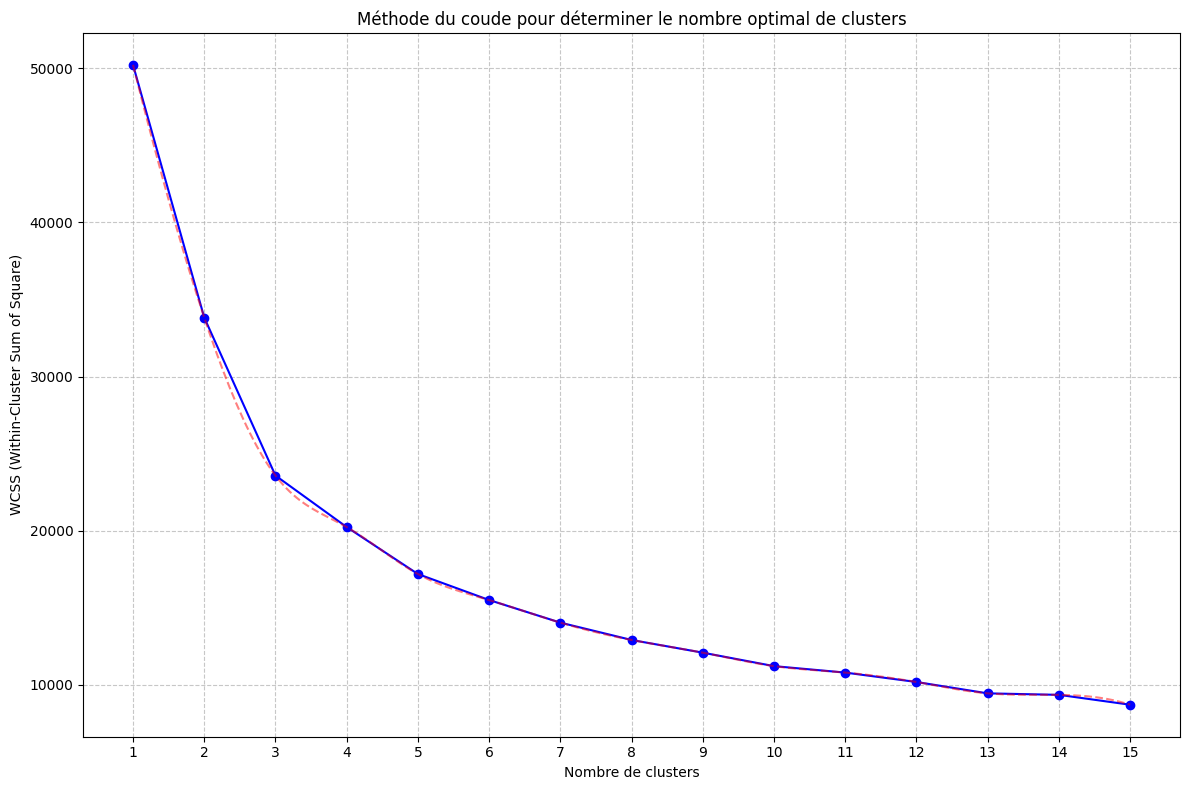


Calcul des scores de silhouette...
Clusters 2: Score de silhouette = 0.9627
Clusters 3: Score de silhouette = 0.8041
Clusters 4: Score de silhouette = 0.8117
Clusters 5: Score de silhouette = 0.5942
Clusters 6: Score de silhouette = 0.5971
Clusters 7: Score de silhouette = 0.5902
Clusters 8: Score de silhouette = 0.4975
Clusters 9: Score de silhouette = 0.4354
Clusters 10: Score de silhouette = 0.4281
Clusters 11: Score de silhouette = 0.3923
Clusters 12: Score de silhouette = 0.3350
Clusters 13: Score de silhouette = 0.4303
Clusters 14: Score de silhouette = 0.3442
Clusters 15: Score de silhouette = 0.3206


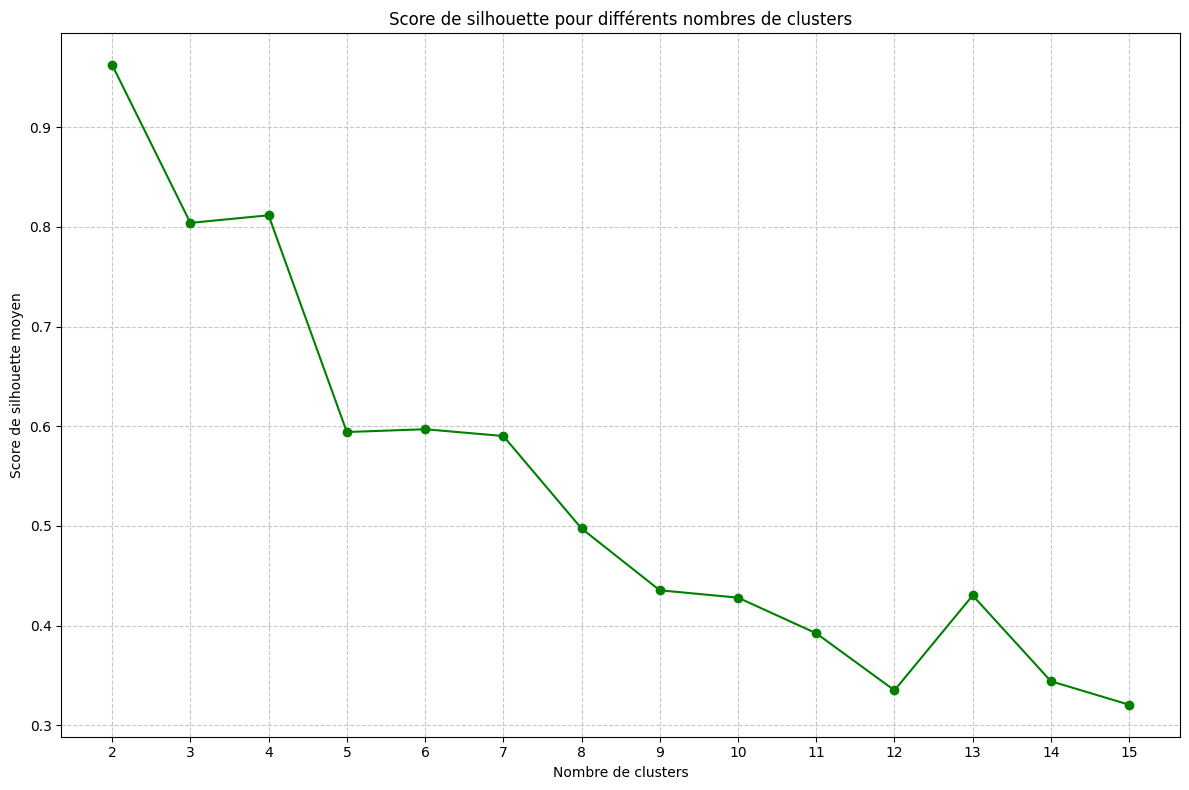


Basé sur ces graphiques, choisissez le nombre optimal de clusters.
Le 'coude' indique généralement le point où ajouter plus de clusters n'apporte plus beaucoup de réduction de variance.
Le score de silhouette le plus élevé indique généralement la meilleure séparation des clusters.


In [ ]:
# Méthode du coude pour déterminer le nombre optimal de clusters
wcss = []  # Within-Cluster Sum of Square
max_clusters = 15  # Tester jusqu'à 15 clusters

print("Calcul de la méthode du coude...")
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_kmeans_scaled)
    wcss.append(kmeans.inertia_)
    print(f"Clusters {i}: WCSS = {kmeans.inertia_:.2f}")

# Tracer la courbe du coude
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='blue')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Square)')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, max_clusters + 1))

# Ajouter une ligne de tendance pour mieux visualiser le "coude"
from scipy.interpolate import make_interp_spline
x = np.array(range(1, max_clusters + 1))
y = np.array(wcss)
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)
plt.plot(x_smooth, y_smooth, '--', color='red', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculer les ratios de variance expliquée pour aider à la décision
from sklearn.metrics import silhouette_score
silhouette_scores = []

print("\nCalcul des scores de silhouette...")
for i in range(2, max_clusters + 1):  # La silhouette n'est pas définie pour k=1
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_kmeans_scaled)
    silhouette_avg = silhouette_score(df_kmeans_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Clusters {i}: Score de silhouette = {silhouette_avg:.4f}")

# Tracer le score de silhouette
plt.figure(figsize=(12, 8))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='green')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette moyen')
plt.title('Score de silhouette pour différents nombres de clusters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(2, max_clusters + 1))
plt.tight_layout()
plt.show()

print("\nBasé sur ces graphiques, choisissez le nombre optimal de clusters.")
print("Le 'coude' indique généralement le point où ajouter plus de clusters n'apporte plus beaucoup de réduction de variance.")
print("Le score de silhouette le plus élevé indique généralement la meilleure séparation des clusters.")

Score de silhouette : Bien que 2 clusters offrent le meilleur score (0,96), on observe que le score reste relativement élevé jusqu'à 4 clusters (≈0,81), puis chute brutalement à 5 clusters (≈0,59). Cela suggère que 4 est le nombre maximal de clusters avant une perte significative de qualité.
Méthode du coude : Sur le second graphique, on peut identifier un "coude" assez net autour de 3-4 clusters. Après ce point, la courbe devient plus graduelle, indiquant que l'ajout de clusters supplémentaires n'améliore plus significativement l'homogénéité.
Compromis : 4 clusters offre un bon équilibre entre:

Une granularité suffisante pour identifier des groupes distincts dans vos données
Une qualité de clustering encore élevée (bon score de silhouette)
Une homogénéité intra-cluster acceptable (WCSS raisonnable)

In [ ]:

# Normaliser les données pour le clustering
scaler = StandardScaler()
df_kmeans_scaled = pd.DataFrame(scaler.fit_transform(df_kmeans),index=df_kmeans.index,columns=df_kmeans.columns)
# Appliquer K-means avec k=10 (ou autre valeur de votre choix)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_kmeans_scaled)
epci_features['cluster'] = clusters


# Afficher la répartition des clusters
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("\nRépartition des EPCI dans les clusters:")
print(cluster_counts)



Répartition des EPCI dans les clusters:
0    1067
1      22
2       1
3     125
4      10
Name: count, dtype: int64


In [30]:
epci_features['geometry'] = epci_features['geometry'].apply(convert_if_string)
epci_features = gpd.GeoDataFrame(epci_features, geometry='geometry')

/tmp/ipykernel_104184/2946997748.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', n_clusters)  # 'tab20', 'viridis', etc.


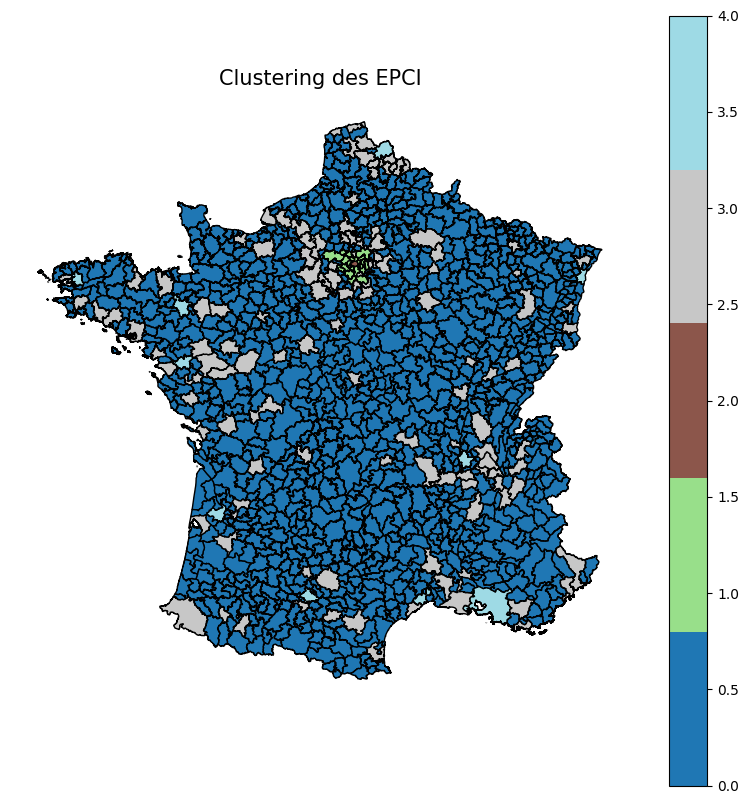

In [33]:
colors = plt.cm.get_cmap('tab20', n_clusters)  # 'tab20', 'viridis', etc.

# Associer une couleur à chaque cluster
epci_features['color'] = epci_features['cluster'].apply(lambda x: colors(x))

# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 10))
epci_features.plot(column='cluster', cmap=colors, legend=True, edgecolor="black", ax=ax)

# Personnalisation
ax.set_title("Clustering des EPCI", fontsize=15)
ax.axis("off")  # Supprimer les axes

# Afficher la carte
plt.show()